In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt 


In [2]:
## RERUN setup 

PORT = 8813
rr.init("SHOUT_SEGMENTATION_DUMB")
rr.connect(addr=f'127.0.0.1:{PORT}')
# rr.save("outliers_0328.rrd")

In [3]:
#######
# Data 
#######

"""get data -- first few frames contain background only (overlaps with part1 video), and SHOUT comes in"""
path = os.path.join(b3d.get_assets_path(), "shared_data_bucket/input_data/demo_reel_place_and_pickup.r3d.video_input_part2.npz")  # frames 44 to 76 in original data
video_input = b3d.VideoInput.load(path) 

subsampling_frame = 5

image_width, image_height, fx,fy, cx,cy,near,far = np.array(video_input.camera_intrinsics_depth)
image_width, image_height = int(image_width), int(image_height)
fx,fy,cx,cy,near,far = float(fx),float(fy), float(cx),float(cy),float(near),float(far)

rgbs_all = video_input.rgb / 255.0
xyzs = video_input.xyz[:-1:subsampling_frame, ...]
rgbs = rgbs_all[:-1:subsampling_frame, ...]

# Resize rgbs to be same size as depth.
rgbs_resized = jnp.clip(jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    rgbs, (xyzs.shape[1], xyzs.shape[2], 3), "linear"
), 0.0, 1.0)
 
# # Get GT camera poses.
gt_camera_poses = jax.vmap(lambda x,y: Pose(x,y), in_axes=(0,0))(
    video_input.camera_positions,
    video_input.camera_quaternions
)[::subsampling_frame, ...]

(33, 256, 192, 3)


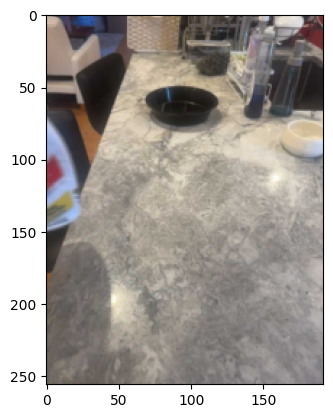

In [4]:
print(rgbs_resized.shape)  # how many frames are there
plt.imshow(rgbs_resized[3])  # at frame 3 the SHOUT comes in

##### Part 1 Background mesh building + Initialize camera pose 

In [5]:
#######
# Build a FULL mesh of the background scene from the 
# last frame that does NOT contain the SHOUT. (not masking anything out)
# TODO: Use mesh + inferred pose from previous part of the demo. 
#######

TIME_FOR_MESH = 2 

point_cloud_for_mesh = xyzs[TIME_FOR_MESH].reshape(-1, 3)
colors_for_mesh = rgbs_resized[TIME_FOR_MESH].reshape(-1, 3)

_bg_vertices, bg_faces, bg_vertex_colors, bg_face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud_for_mesh, colors_for_mesh, 0.003 * 2 * jnp.ones(len(colors_for_mesh))
)

bg_object_pose = Pose.from_translation(_bg_vertices.mean(0))  # (approximate) CAMERA frame object pose
bg_vertices = bg_object_pose.inverse().apply(_bg_vertices)  # (approximate) WORLD frame vertices


In [6]:
# viz initial scene (camera frame)
rr.log("3d/", rr.Transform3D(translation=bg_object_pose.pos, rotation=rr.Quaternion(xyzw=bg_object_pose.quat)))
rr.log(
    "/3d/bg_mesh",
    rr.Mesh3D(
        vertex_positions=_bg_vertices,
        indices=bg_faces,
        vertex_colors=bg_vertex_colors
    ),
    timeless=True
)     

In [7]:
#######
# setup renderer and model functions
#######

renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)
from b3d.model import model_gl_factory

# initialize the model. 
model = model_gl_factory(renderer)

In [8]:
# generate a trace that localizes the background mesh from above
# and sanity-check with the rendering 

color_error, depth_error = (10.0, 0.02)
inlier_score, outlier_prob = (4.0, 0.01)
color_multiplier, depth_multiplier = (1000.0, 1000.0)

bg_arguments = (
        bg_vertices, bg_faces, bg_vertex_colors,
        color_error,
        depth_error,

        inlier_score,
        outlier_prob,

        color_multiplier,
        depth_multiplier
    )

bg_trace, _ = model.importance(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        {
            "camera_pose": Pose.identity(),
            "object_pose": bg_object_pose,
            "observed_rgb": rgbs_resized[TIME_FOR_MESH],
            "observed_depth": xyzs[TIME_FOR_MESH,...,2],
        }
    ),
    bg_arguments
)
bg_obs_rgb, bg_rendered_rgb = bg_trace.get_retval()[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


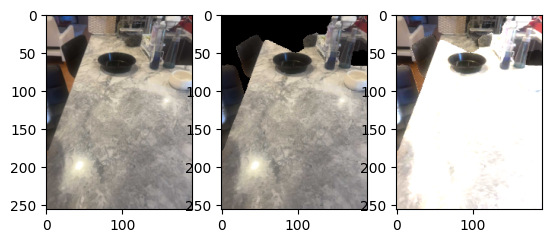

In [9]:
f, axes = plt.subplots(1, 3)
axes[0].imshow(bg_obs_rgb)
axes[1].imshow(bg_rendered_rgb)
axes[2].imshow(bg_obs_rgb + bg_rendered_rgb)

##### Part 2 Camera pose inference + SHOUT outlier

In the first iteration of solving this clustering problem, we will simply show that the novel object (hand+Shout) is an outlier. That is, given the background mesh of a static scene with "good" localization via camera pose inference, pixels corresponding to a novel object should be clearly thresholded by a perceptual error function as an "outlier". 

This problem works towards online recognition + mesh learning of a novel object, but for now, we do not attempt to acquire mesh(es) nor localize the hand+shout in a zero-shot manner. 

In [10]:
############
# Setup cam pose inference
############

### TODO the model only supports one object; 
# add 'num_objects' param conditioned by notion of "clump of outlier => num_objects += 1"


## model and inference. 
model = model_gl_factory(renderer)
importance_jit = jax.jit(model.importance)
update_jit = jax.jit(model.update)

## trace update handlers.
enumerator = b3d.make_enumerator(["camera_pose"])
enumerator_observations = b3d.make_enumerator(["observed_rgb", "observed_depth"])
update_jit = jax.jit(lambda key, trace, choices: model.update(key, trace, choices, genjax.Diff.tree_diff_no_change(trace.get_args()))[0])


## setup enumeration 
translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.01, 0.01, 5),
        jnp.linspace(-0.01, 0.01, 5),
        jnp.linspace(-0.01, 0.01, 5),
    ),
    axis=-1,
).reshape(-1, 3))

rotation_deltas = jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), 100),
    Pose.identity(),
    0.001, 100.0
)


In [11]:
@jax.jit
def enumerative_proposal_camera_pose(trace, key):
    key = jax.random.split(key)[0]

    test_poses_tr = trace["camera_pose"] @ translation_deltas
    potential_scores = enumerator.enumerate_choices_get_scores(
        trace, jax.random.PRNGKey(0), test_poses_tr
    )
    
    # top k translations 
    k = 5
    top_scores, top_pose_idxs = jax.lax.top_k(potential_scores, k)

    def _eval_trace(curr_best_pose_score, pose_idx):
        _, curr_best_score = curr_best_pose_score

        test_poses_rot = test_poses_tr[pose_idx] @ rotation_deltas
        potential_scores = enumerator.enumerate_choices_get_scores(
            trace, jax.random.PRNGKey(0), test_poses_rot
        )
        top_idx = potential_scores.argmax()
        top_score = jnp.max(potential_scores)
        curr_best_pose_score = jax.lax.cond(
            top_score > curr_best_score,
            lambda : (test_poses_rot[top_idx], top_score),
            lambda : curr_best_pose_score
        )
        
        return curr_best_pose_score, curr_best_score
          
    top_pose_and_score, _ = jax.lax.scan(_eval_trace, 
                                        (test_poses_tr[top_pose_idxs[0]], top_scores[0]),
                                        top_pose_idxs)
    
    trace = enumerator.update_choices(
        trace, jax.random.PRNGKey(0), top_pose_and_score[0]
    )
    return trace, key


In [12]:
######
# Camera pose tracking
######
CAMERATRACK_START_T = 0
CAMERATRACK_END_T = len(rgbs_resized)

key = jax.random.PRNGKey(0)
chains = []
for T_observed_image in tqdm(range(CAMERATRACK_START_T, CAMERATRACK_END_T, 1)):
    bg_trace = enumerator_observations.update_choices(bg_trace, key,
        rgbs_resized[T_observed_image],
        xyzs[T_observed_image,...,2]
    )
    for _ in range(1):
        bg_trace,key = enumerative_proposal_camera_pose(bg_trace, key)
    chains.append(bg_trace["camera_pose"])

100%|██████████| 33/33 [00:17<00:00,  1.92it/s]


In [13]:
# visualize whole mesh

viz_trace = bg_trace

rendered_vizs = []
inlier_vizs = []

for T_observed_image in tqdm(range(len(chains))):
    viz_trace = enumerator_observations.update_choices(viz_trace, key,
        rgbs_resized[T_observed_image],
        xyzs[T_observed_image,...,2]
    )
    cam_pose_viz = chains[T_observed_image] 
    viz_trace = enumerator.update_choices(viz_trace, key, cam_pose_viz)
    vizs = b3d.rerun_visualize_trace_t(viz_trace, T_observed_image) # (observed_rgb, rendered_rgb, observed_depth, rendered_depth, inlier_match_mask, error)
    rendered_vizs.append(vizs[1])
    inlier_vizs.append(vizs[4])
    
    rr.log("/point_cloud",
        rr.Points3D(
            xyzs[T_observed_image].reshape(-1, 3),
        )
    )
    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = viz_trace.get_retval()
    rr.log("/point_cloud",
        rr.Points3D(
            xyzs[T_observed_image].reshape(-1, 3),
        )
    )
    rr.log("/rendered_point_cloud",
        rr.Points3D(
            b3d.xyz_from_depth(rendered_depth, fx, fy, cx, cy).reshape(-1, 3),
        )
    )

100%|██████████| 33/33 [00:06<00:00,  4.85it/s]


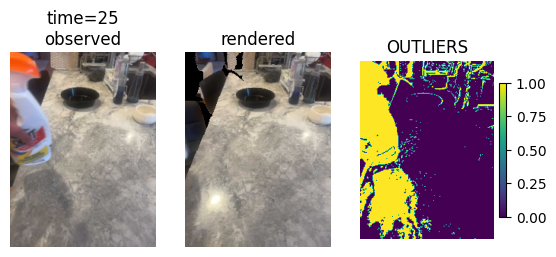

In [21]:
f, axes = plt.subplots(1, 3)
for ax in axes: ax.axis('off')

viz_idx = 5  # 3 onwards have SHOUT

axes[0].imshow(rgbs_resized[viz_idx]) 
axes[1].imshow(rendered_vizs[viz_idx]) 
heat = axes[2].imshow(1-inlier_vizs[viz_idx]*1.0) 
f.colorbar(heat,fraction=0.046, pad=0.04)

axes[0].title.set_text(f"time={viz_idx * subsampling_frame}\nobserved")
axes[1].title.set_text(f"rendered")
axes[2].title.set_text(f"OUTLIERS")